# Past Earth Network Emulator Meeting: Lab 2


by Alan Saul and Richard Wilkinson. 

In this tutorial we will focus on combining covariance functions to get the kind of behaviour we want, and demonstrate how everything we've seen so far carries over to problems where the dimension of X is greater than 1. 

We recommend you finish the first tutorial before attempting this one.




In [1]:
import GPy, numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)
%matplotlib inline
from sklearn.datasets import fetch_mldata

## General background

As a reminder from the previous lab, it is useful to visualise the emulator model both before any data is observed and after data is observed. This allows us to intuitively see what kind of prior assumptions we are making about the model, by making specific assumptions about the kernel choice.

In [2]:
# First generate some very simple data
X_observed = np.array([-1, 1.5, 3])[:, None]
Y_observed = np.sin(X_observed)

# And make a choice of kernel, that will define the types of functions that are probable under the prior
kern = GPy.kern.RBF(1)

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


(-4.0, 4.0)

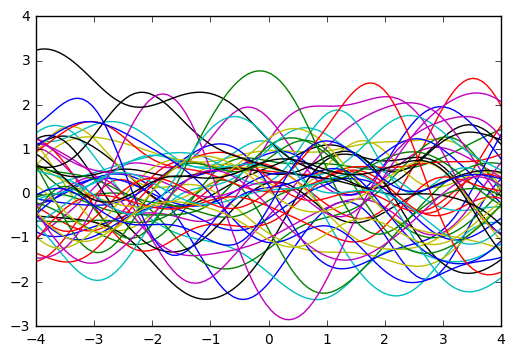

In [3]:
# We wish to predict over an input range -4 to 4
X_pred = np.linspace(-4, 4, 100)[:, None]

# The GP prior covariance is very simple
prior_mean = np.zeros(X_pred.shape[0])
prior_cov = kern.K(X_pred, X_pred)

# Draw some example functions to visualise
prior_F = np.random.multivariate_normal(prior_mean, prior_cov, 50)

# Plot them with respect to the input
_ = plt.plot(X_pred, prior_F.T)
plt.xlim(X_pred.min(), X_pred.max())

Now we have visualised the prior, we will visualise the likely posterior functions, given that we observe the data, and the likelihood is taken into account - that is that we expect the observed data to be some small Gaussian corruption of the function that generated the data.

(-4.0, 4.0)

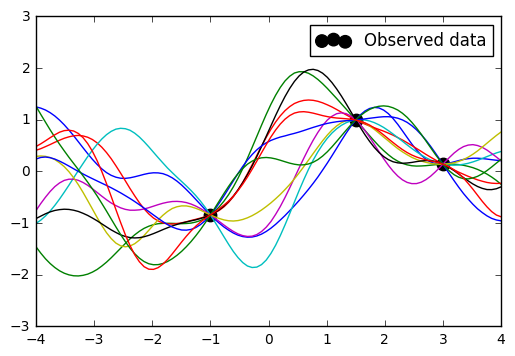

In [4]:
# Make the model that includes the likelihood and the prior
m = GPy.models.GPRegression(X_observed, Y_observed, kernel=kern)
# Find the MAP values of the parameters and hyperparameters
m.optimize()

# Make predictions of the posterior at the prediction locations
posterior_mean, posterior_cov = m.predict(X_pred, full_cov=True)

posterior_F = np.random.multivariate_normal(posterior_mean.flatten(), posterior_cov, 10)

_ = plt.plot(X_pred, posterior_F.T)
# Plot the data on top
_ = plt.scatter(X_observed, Y_observed, marker='o', color='k', s=80, label='Observed data')
plt.legend()
plt.xlim(X_pred.min(), X_pred.max())

This code will be useful for visualising prior and posterior samples of the models that follow in the rest of this lab sheet.

## 1. Combining covariance functions.

We will use the classic Mauna Loa dataset of CO2 measurements through time to illustrate how we can combine different covariance functions. This example is also likely to serve as a useful illustration of how GPs can sometimes be tricky to work with, and why it is necessary to always check your fitted model.

Populating the interactive namespace from numpy and matplotlib


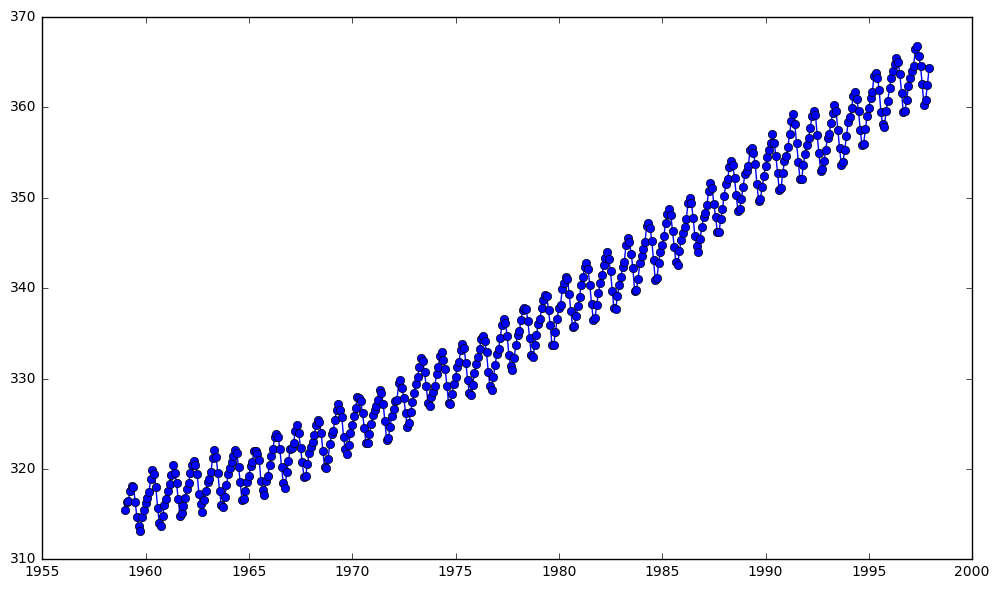

In [5]:
data = fetch_mldata('mauna-loa-atmospheric-co2').data
X = data[:, 1]
y = data[:, 0]
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7)
plt.plot(X,y, '-o')

If we just fit a GP, then we can easily find a function that follows the general trend. But note that when we extrapolate, GPs revert to their mean, which is zero in this case. 

In [6]:
X=X[:,None] # we need to reshape X into a matrix with n rows
y=y[:,None] # we need to reshape y into a column with n rows.

Since the we have to complete this lab sheet is relatively short, we will sub-sample half the data to make things run quicker. When you have more time, try running it with the entire dataset.

In [7]:
X = X[::2, :]
y = y[::2, :]

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


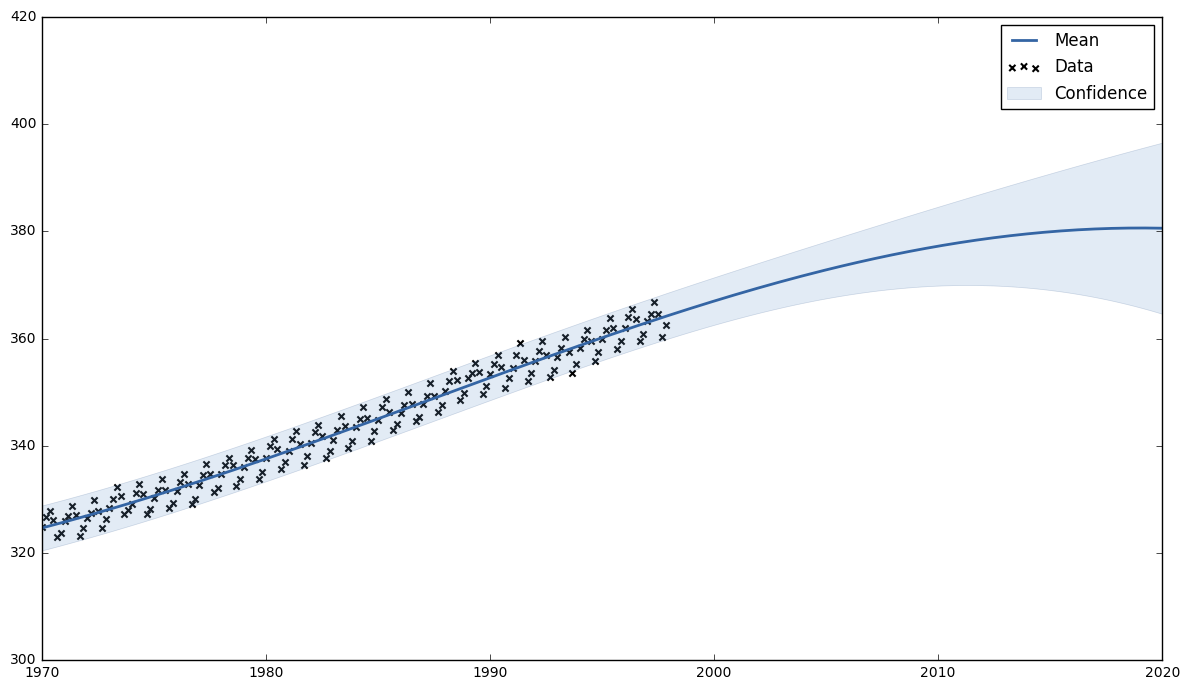

In [8]:
k1 = GPy.kern.RBF(1, lengthscale=5.0)
m = GPy.models.GPRegression(X,y,k1)
m.optimize()
m.plot((1970,2020))

Note that we can make the model fit the data perfectly by specifying likelihood with a very small noise term, but this model clearly has no predictive skill.

 /Users/pmzrdw/GPy/GPy/likelihoods/gaussian.py:101: RuntimeWarning:invalid value encountered in sqrt


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


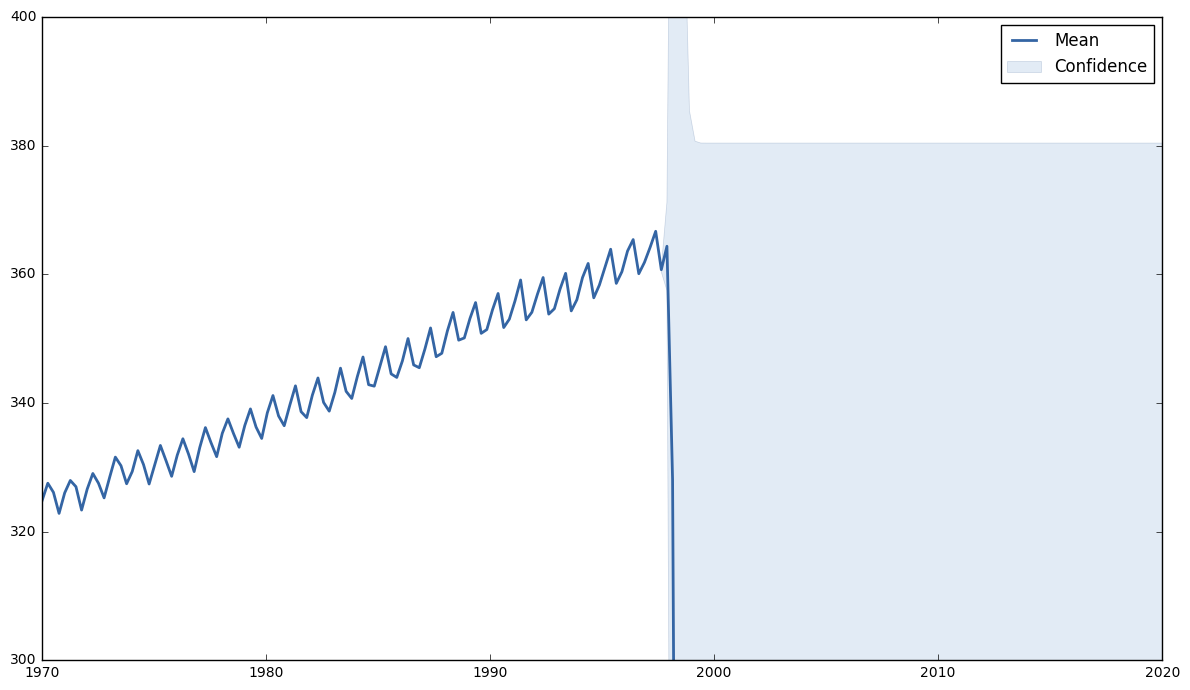

In [9]:
k2 = GPy.kern.RBF(1, variance=5.0, lengthscale=0.5)
m2 = GPy.models.GPRegression(X,y,k2)
m2.likelihood.variance.constrain_fixed(0.00001)
m2.optimize()
m2.plot_f((1970,2020), ylim=(300,400))

### Exercise 1a
Check that if we predict far enough out into the future using the first GP (`m`), then the model predicts a CO2 level of 0.

How can we fix this? Well firstly, we may want to add a mean function to capture the linear increasing trend. Although not heavily used, GPy allows for relatively simple parametric mean functions to be learnt jointly along with the rest of the model, when a simple GP regression model is used.

Often it is desirable to incorporate the effect of the mean functions within the kernel, though this can lead to a more difficult to interpret model. For example, to create a linear trend, we could combine a linear kernel and a bias kernel, by adding the two. This fits a model of the form
$$y \sim a+bx + \epsilon$$
to the data, where priors for a and b are implictly set and integrated over. This model is then equivalent to Bayesian linear regression when $\epsilon$ is Gaussian.

Combining different kernels is easy in GPy, as the + and * operators have been overloaded so that if we write something like k1+k2 where k1 and k2 are both kernels, then GPy knows to do the correct calculation to give us a working covariance function.

Optimization restart 1/10, f = 575.8698764069161
Optimization restart 2/10, f = 575.7478101200675
Optimization restart 3/10, f = 805.5645540551819
Optimization restart 4/10, f = 572.0639311651566
Optimization restart 5/10, f = 572.0639325271474
Optimization restart 6/10, f = 572.0639312842986
Optimization restart 7/10, f = 575.0208570141517
Optimization restart 8/10, f = 740.8656269792419
Optimization restart 9/10, f = 920.417212993062
Optimization restart 10/10, f = 574.530914593648

Name : GP regression
Objective : 572.0639311651566
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  sum.linear.variances     |  1.70333000113  |      +ve      |        
  sum.bias.variance        |  5040388.25089  |      +ve      |        
  Gaussian_noise.variance  |  6.90693429117  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


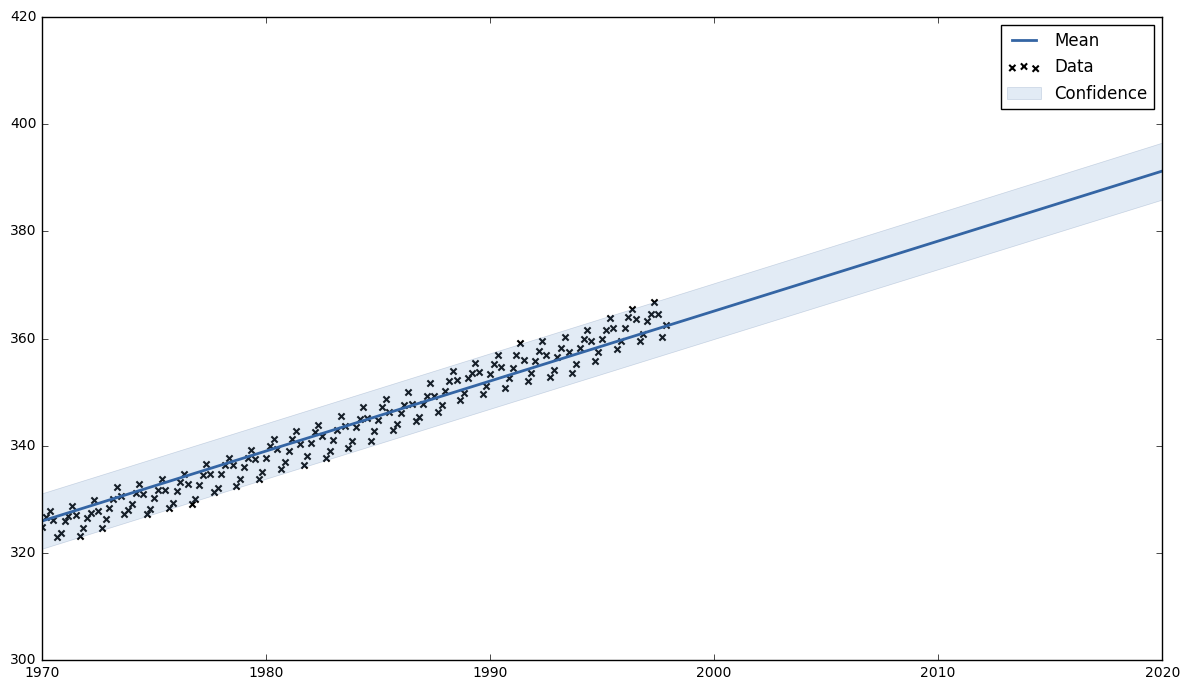

In [10]:
k2 = GPy.kern.Linear(1)+GPy.kern.Bias(1)
m2 = GPy.models.GPRegression(X,y,k2)
m2.optimize_restarts(10)
print(m2)
m2.plot((1970,2020))

### Exercise 1b
Simulate prior realisations from a GPy using a bias and linear kernel. Convince yourself that the bias kernel adds a constant mean to the GP, and the linear kernel gives us a constant trend.



For now however, to keep interpretation simple, we will consider the use of a simple mean function of the Gaussian process, $$\mu = a+bx$$

First lets get some initial idea about what sort of values these gradient and offset values may take by considering the data. This will allow us to specify a prior over what values we expect, based on some initial belief. By playing around a little with the gradient offset we find that a big negative offset is required, and the gradient, clearly positive, is relatively small. We do not need to obtain an exact fit here as the model will learn the true values.

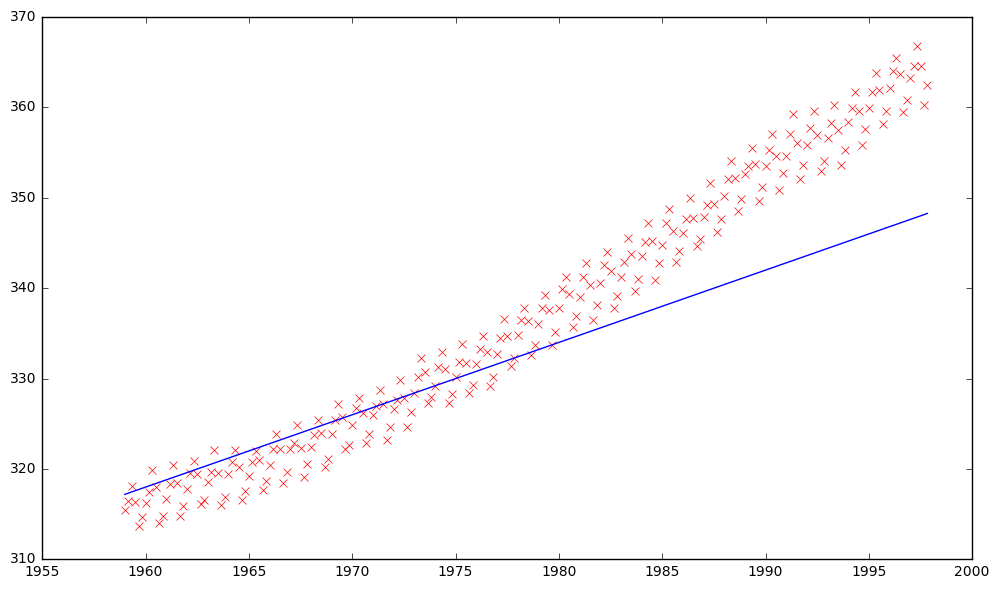

In [11]:
plt.plot(X,y,'rx')

a=0.8
b=-1250
plt.plot(X, a*X + b, 'b')

This indicates that the since offset may be quite negative, and should be given a suitably flexible prior. The linear term is clearly positive and a relatively low value, and so a prior that contains a positive constraint should be used, such as a Gamma.

 /Users/pmzrdw/GPy/GPy/core/parameterization/priors.py:301: RuntimeWarning:divide by zero encountered in log


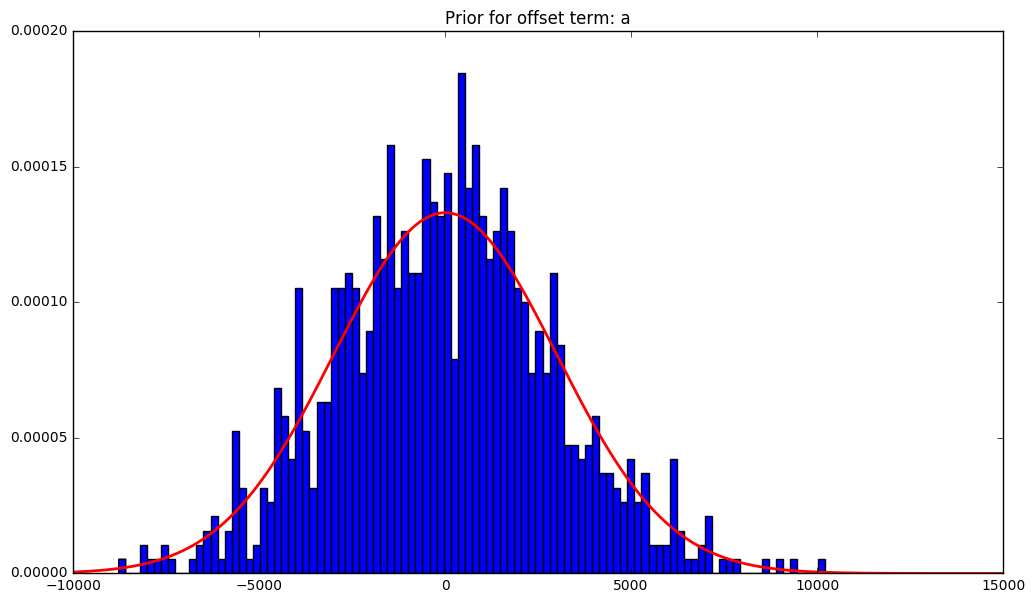

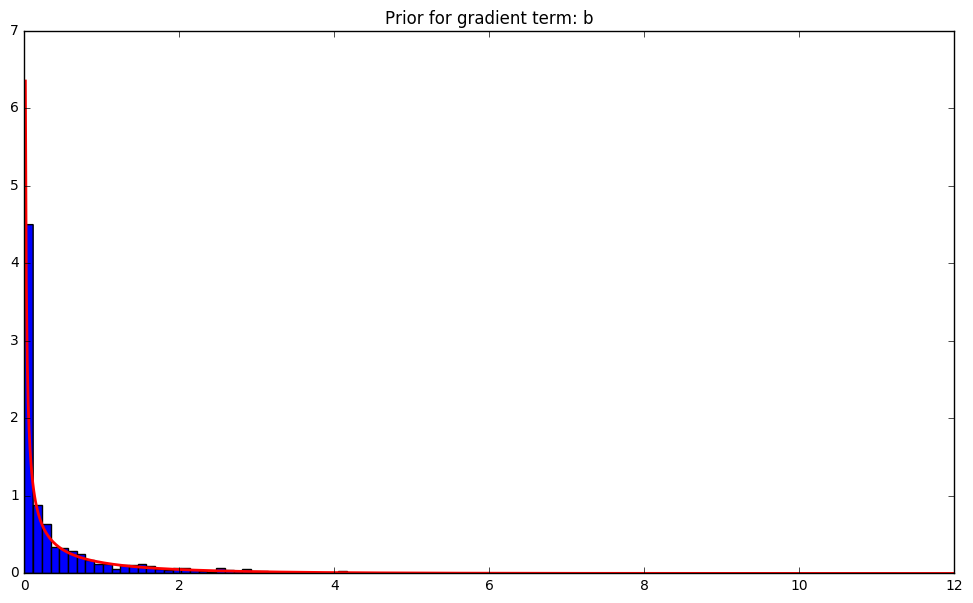

In [12]:
offset_prior = GPy.priors.Gaussian(mu=0, sigma=3000)
gradient_prior = GPy.priors.Gamma.from_EV(E=0.5, V=1.0)
plt.figure()
offset_prior.plot()
plt.title("Prior for offset term: a")
plt.figure()
gradient_prior.plot()
plt.title("Prior for gradient term: b")

To make a parametric mean function in GPy, we construct a linear function of the input added to the constant function of the input, this forms our linear mean function that contains two parameters. We can then assign these parameters priors and subsequently learn a MAP value for them.

In [13]:
k2 = GPy.kern.RBF(1, lengthscale=0.5, variance=5.0)
linear_mean = GPy.mappings.Additive(GPy.mappings.Linear(input_dim=1,output_dim=1),
                                    GPy.mappings.Constant(input_dim=1, output_dim=1))
m2 = GPy.models.GPRegression(X,y,k2,mean_function=linear_mean)
m2.mapping.linmap.set_prior(gradient_prior)
m2.mapping.constmap.set_prior(offset_prior)
m2.likelihood.variance.constrain_fixed(0.00001)
m2.rbf.lengthscale = 1.0
m2

GP_regression.,value,constraints,priors
mapping.linmap.A,[ 1.56265184],+ve,"Ga(0.25, 0.5)"
mapping.constmap.C,0.0,,"N(0, 3e+03)"
rbf.variance,5.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


We know these values are just initial guesses, and so we must optimise the gradient and offset parameters of the mean function, the hyperparamers of the model, and the Gaussian noise variance together.

Optimization restart 1/10, f = 568.9680015436638
Optimization restart 2/10, f = 568.9680015448355
Optimization restart 3/10, f = 568.9680017552962
Optimization restart 4/10, f = 964.1857965570218
Optimization restart 5/10, f = 479.11803569804357
Optimization restart 6/10, f = 547.8806697196857
Optimization restart 7/10, f = 541.1982783753965
Optimization restart 8/10, f = 592.6281304118901


 /Users/pmzrdw/GPy/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square


Optimization restart 9/10, f = 961.5543583850347
Optimization restart 10/10, f = 632.3163906747283


GP_regression.,value,constraints,priors
mapping.linmap.A,[ 1.58185984],+ve,"Ga(0.25, 0.5)"
mapping.constmap.C,-2792.55009174,,"N(0, 3e+03)"
rbf.variance,13.6977151684,+ve,
rbf.lengthscale,0.212032532949,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


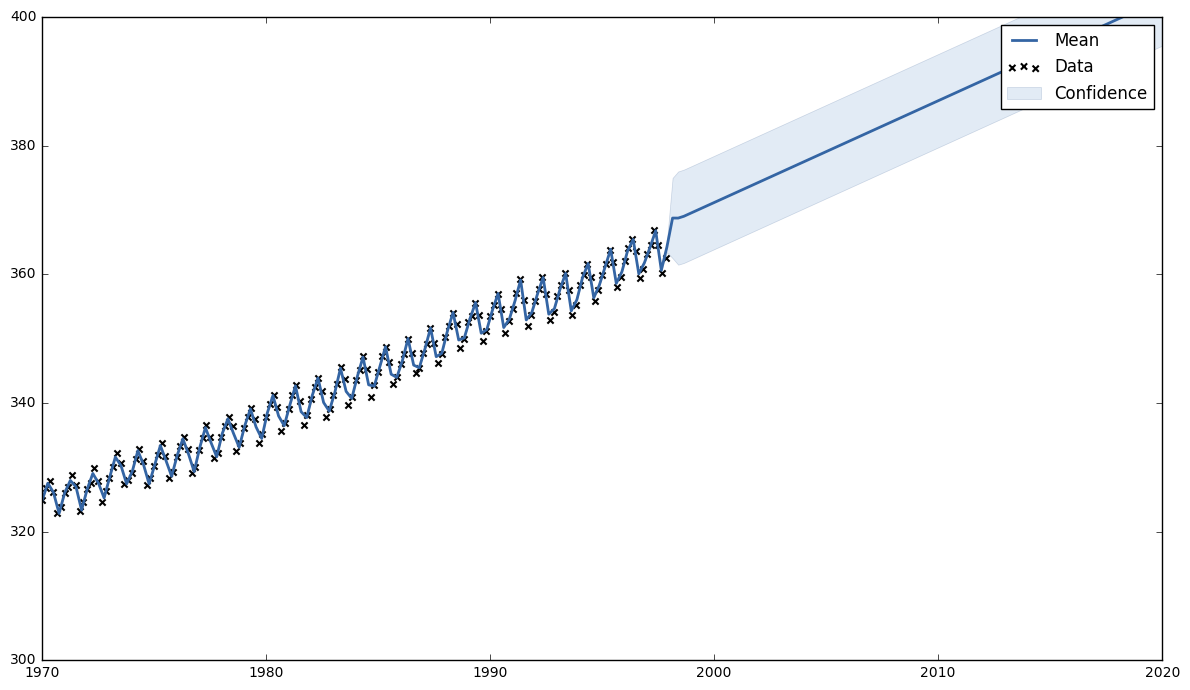

In [14]:
m2.optimize_restarts(10, robust=True)
m2.plot((1970,2020), ylim=(300,400))
m2

Since many different minima are found upon different optimisations, this implies that there are several modes in the log-likelihood space. We consider the value with the lowest negative log-likelihood to be the most promising mode.

### Periodicity

Note that although a linear trend has now been introduced, and so CO2 is expected to rise, the clear periodic component is not considered. It should also be clear from the data that a linear trend is not quite correct, in fact it is slightly non-linear, or a sum of a linear and non-linear function.

One method of handling the periodicity is to consider that the underlying function is periodic in the short term (from year to year), but its amplitude is modulated by a longer term non-linear function, i.e. it is modulated in a non-linear way. In addition to this there longer term function that suggests that CO2 levels are rising, as before.

This prior assumption about the form of the underlying function can be incorporated by considering the kernel to be a product between a short term periodic kernel with period 1, to represent the yearly cycle in CO2 levels, and a long term smooth RBF kernel to change the amplitude. Alongside this there is a kernel that is a non-linear and linear function added together, this allows the overall CO2 levels to rise throughout the previous decades as we saw previously.

This is an example of kernels being combined to make more complex prior beliefs about the form of the function.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 167.74211336169756
Optimization restart 2/10, f = 430.5960020305122
Optimization restart 3/10, f = 117.41328848161277
Optimization restart 4/10, f = 236.2577002499704
Optimization restart 5/10, f = 430.59600640544465
Optimization restart 6/10, f = 523.2308216722556
Optimization restart 7/10, f = 561.5892048636399
Optimization restart 8/10, f = 518.6414130281846


 /Users/pmzrdw/GPy/GPy/kern/src/standard_periodic.py:112: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/standard_periodic.py:113: RuntimeWarning:invalid value encountered in sin
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 9/10, f = 437.0012888408521
Optimization restart 10/10, f = 523.2237309820811


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


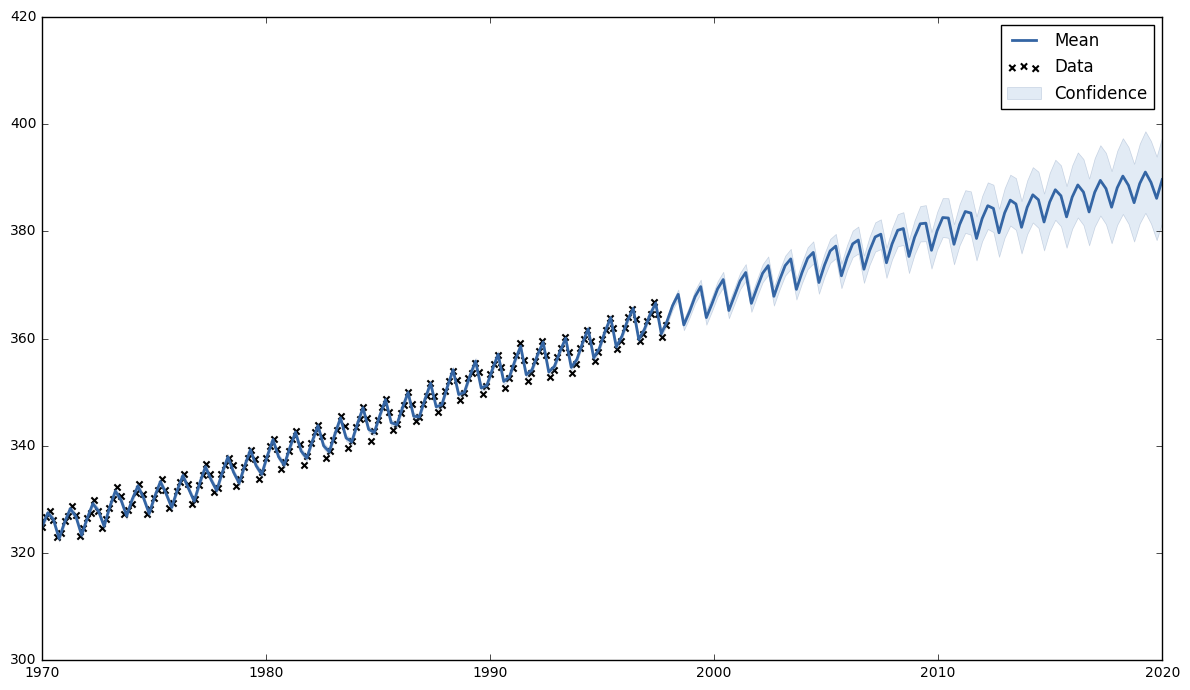

In [26]:
k1 = GPy.kern.RBF(1, lengthscale=5, variance=5.0, name='RBF')
k2 = GPy.kern.Linear(1, name='Linear')+GPy.kern.Bias(1, variance=1000)
k3 = GPy.kern.StdPeriodic(1, lengthscale=1.3, period=1.0, name='Periodic') 
k4 = GPy.kern.RBF(1, lengthscale=90.0, variance=2.4, name='RBF_periodic_multiplier') 
m4 = GPy.models.GPRegression(X,y,k1+k2+k3*k4)
m4.optimize_restarts(10, robust=True)
m4.plot((1970,2020))

This seems to have done the trick. Note that the kernel k3 here is a product between two individual kernels.
Note that this is a somewhat artificial example to illustrate how we can combine kernels. In practice, we may not wish to specify such a detailed kernel.

### Exercise 1c

Experiment with other combinations of kernels to see if you can get a better fit.

### Exercise 1d

In this case we used the linear kernel and bias as a substitute for the mean function we used in the previous example. Try use a mean function instead, do you get a similar result?

We can plot the effect of each individual kernel.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


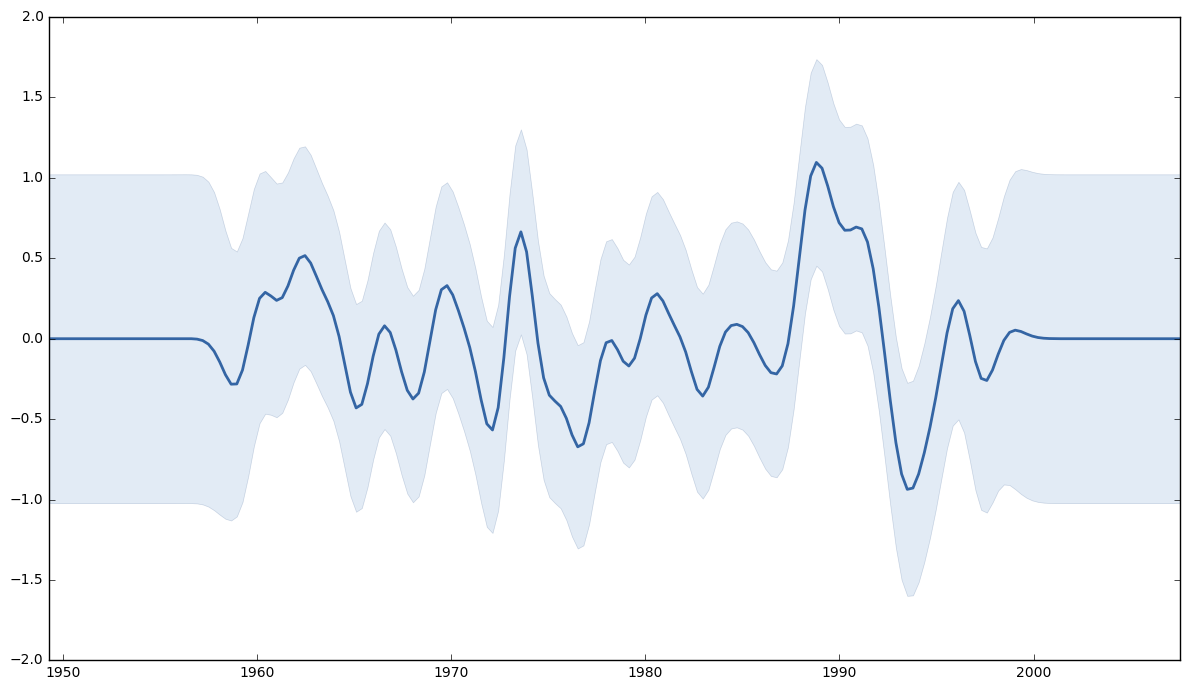

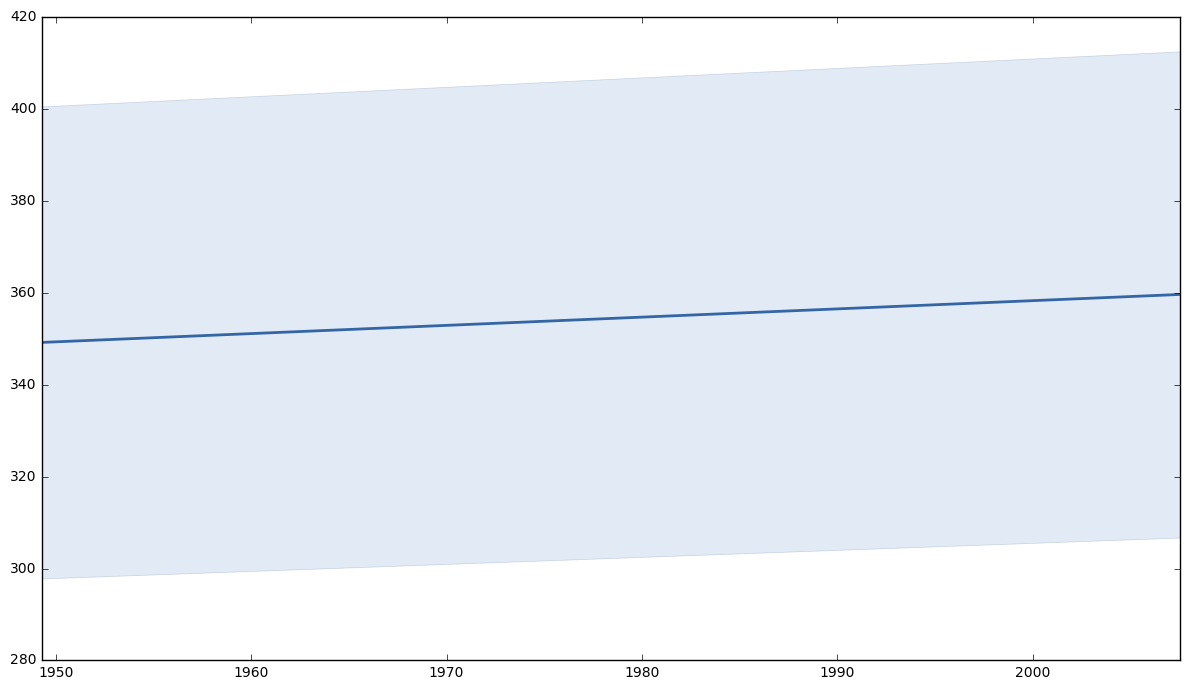

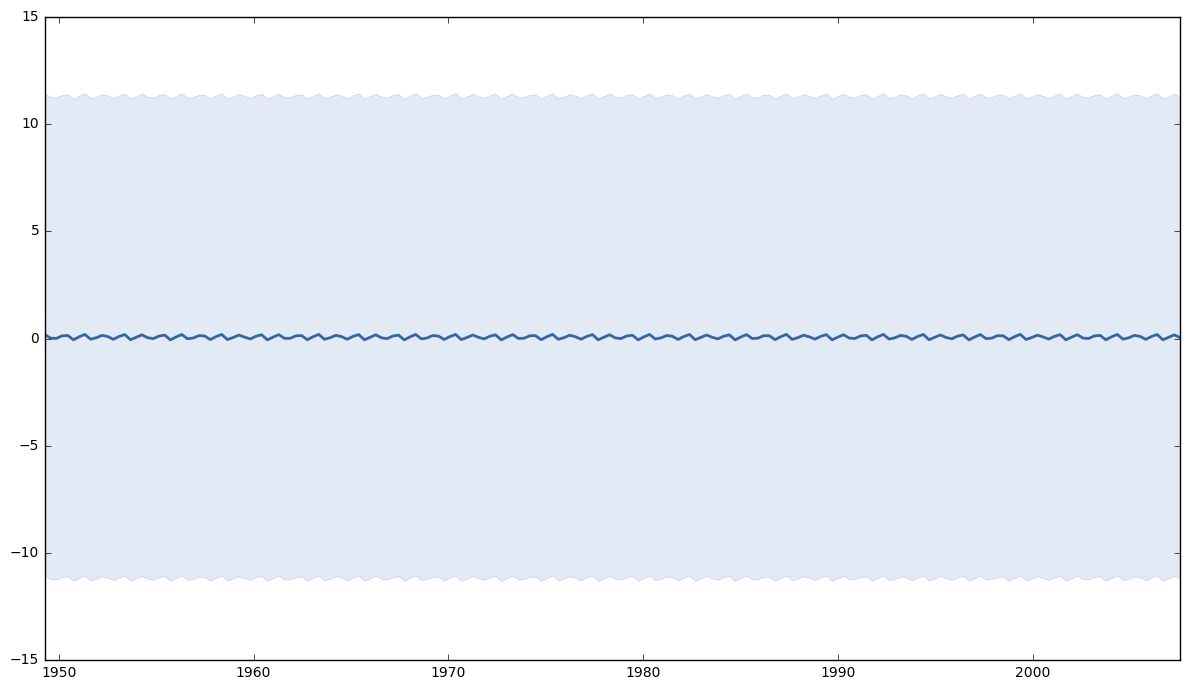

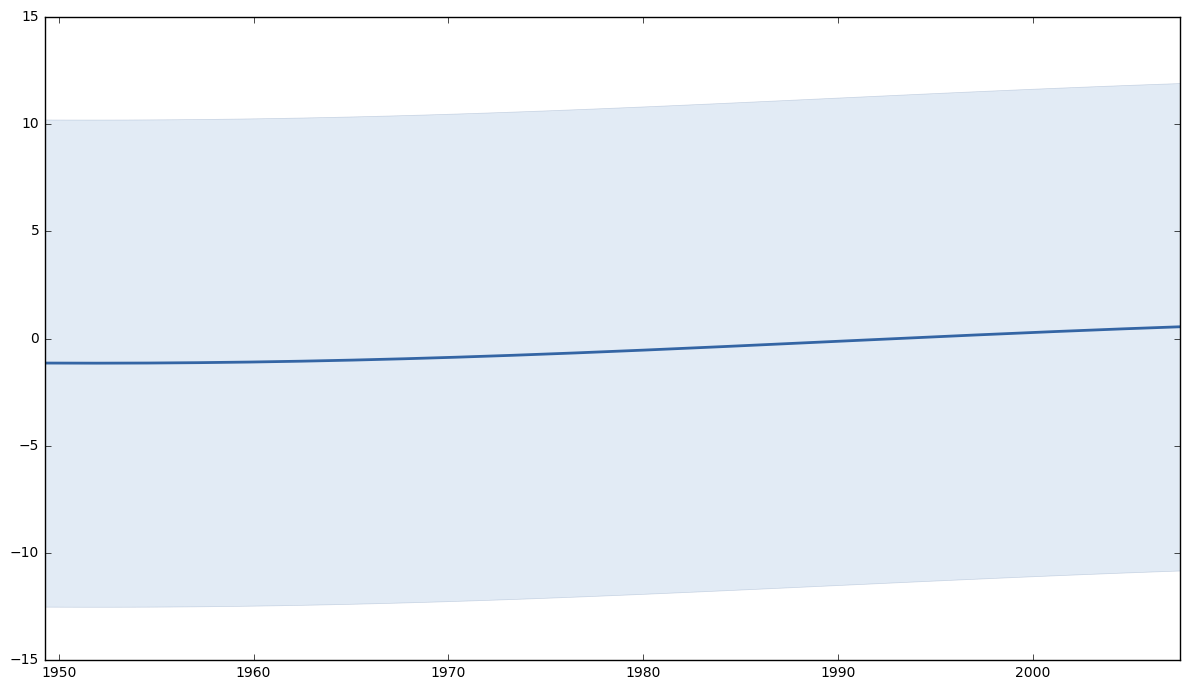

In [30]:
m4.plot(predict_kw=dict(kern=m4.kern.RBF), legend=False, plot_data=False)
m4.plot_noiseless(predict_kw=dict(kern=m4.kern.Linear), legend=False, plot_data=False)
m4.plot_noiseless(predict_kw=dict(kern=m4.kern.mul.Periodic), legend=False, plot_data=False)
m4.plot_noiseless(predict_kw=dict(kern=m4.kern.mul.RBF_periodic_multiplier), legend=False, plot_data=False)

## 2. Multiple inputs

Normally of course, we will have multiple different covariates, i.e., our problem will not be one dimensional. Everything you have seen so far carries across without much change to the general case.

We'll look at a toy example and generate data from 
$$y=sin(x_1)*sin(x_2)+N(0, \sigma^2)$$
in the region $[-3,3]^2$

If you have the `pyDOE` package installed (can be similarly installed with ``pip install pyDOE``, we can create a maximin Latin hypercube design at which to evalute the function. These are a type of design that is close to optimal for building GP regression models. `pyDOE.lhs` by default creates a design on $[0,1]^d$ and so we have had to translated this to $[-3,3]^2$

If you do not have this package install, we will simply use random uniform sampling across the input range.

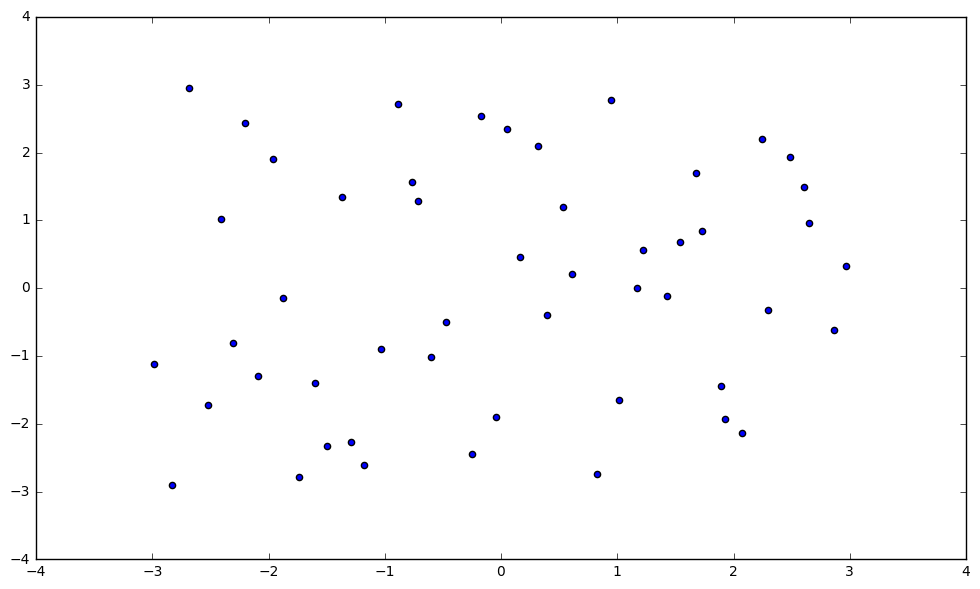

In [31]:
try:
    from pyDOE import lhs
    # sample inputs and outputs from 2d model
    X2 = lhs(2, samples=50, criterion='maximin')*6.-3. # you will need to have installed pyDOE for this to work. 
except:
    # Else uncomment the line below
    X2 = np.random.uniform(-3.,3.,(50,2))

Y2 = np.sin(X2[:,0:1]) * np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

plt.scatter(X2[:,0], X2[:,1])


Now lets fit a GP and visualise the resulting fit.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


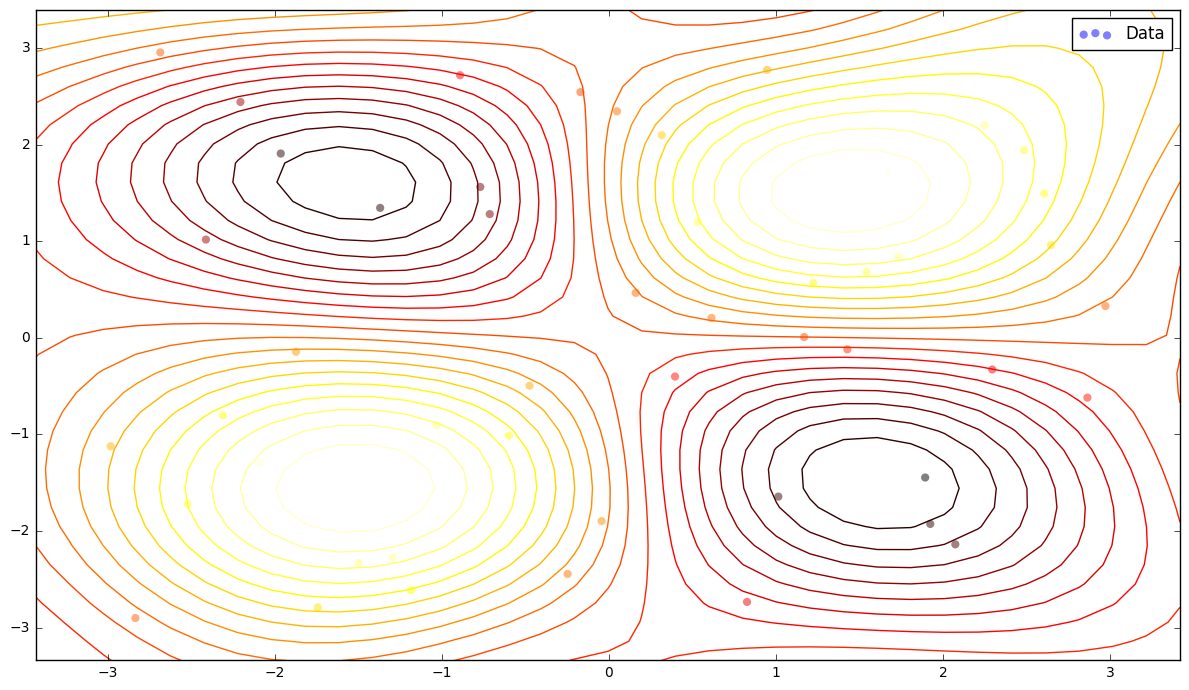

In [32]:
# define kernel, notice the number of input dimensions is now 2
ker = GPy.kern.RBF(input_dim=2, ARD=True)

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

Note that this time RBF is defined with two input dimensions, to handle the 2D input. We will now revisit combining kernels and see how different kernels can be used on different input dimensions.

## Kernels

Kernel construction is modular. Kernels can be created seperately and then easily combined with simple operations such as addition, and multiplication, including over difference spaces. 

### Combining kernels

As we have seen before, in GPy you can easily combine covariance functions you have created using the sum and product operators, + and *. This allows more complex assumptions about our prior belief about the form of the function to be encoded. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


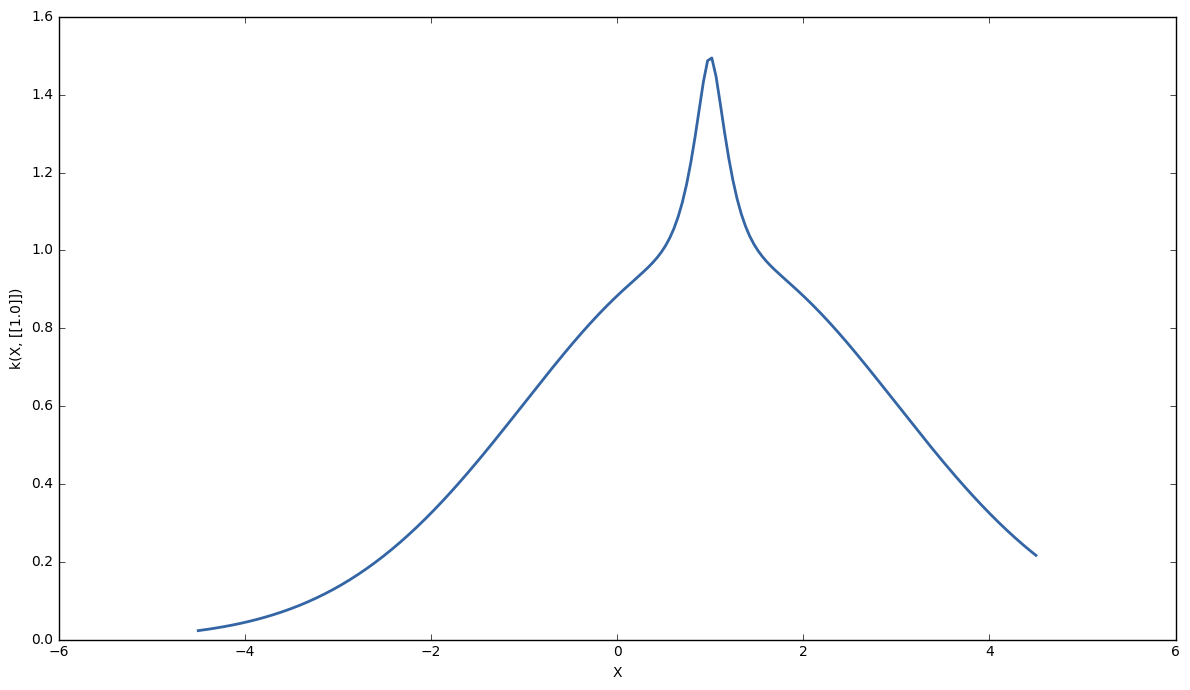

In [33]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern32(1, variance=0.5, lengthscale=0.2)
kern = kern1 + kern2
print(kern)

kern.plot()

Or if we wanted to multiply them we can write

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


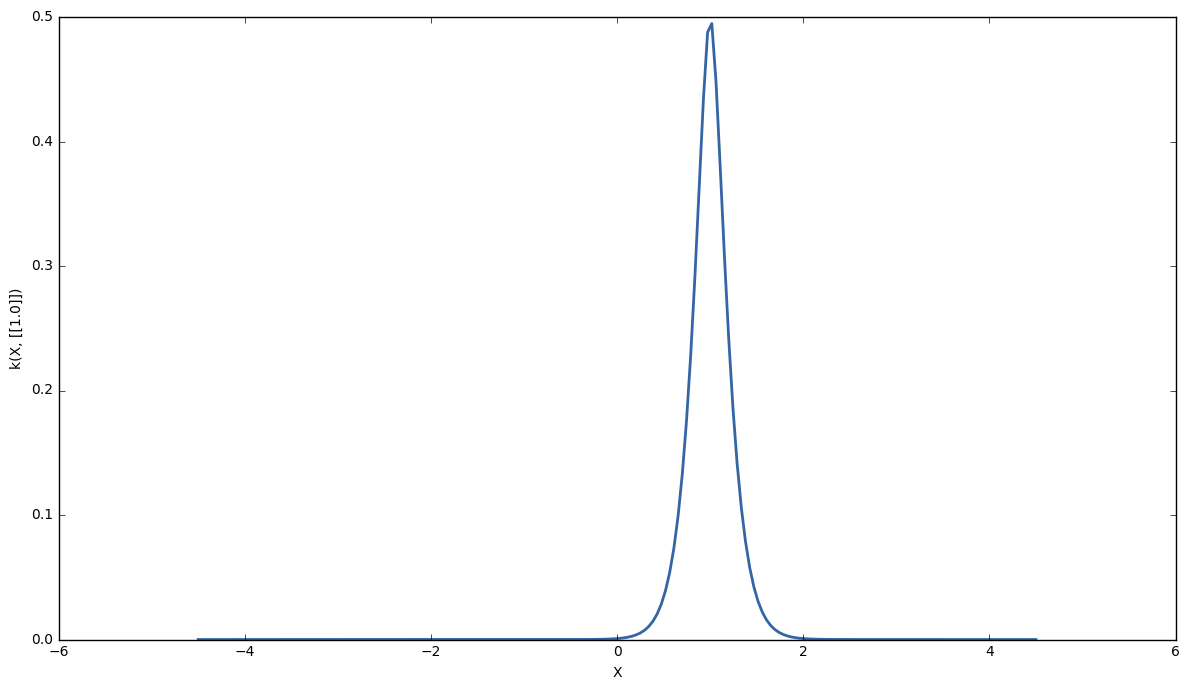

In [34]:
kern = kern1*kern2
print(kern)
kern.plot()

### Exercise 2a

Try plotting samples of these functions as described at the top of this lab session, can you interpret the effect of the addition and multiplication?


### Active dimensions

It may be that you only want one kernel to work one set of dimensions, and another kernel on another set. That is the two kernels work on different domains of the input. In GPy this capability is provided with active_dims argument to the kernel, which tell the kernel what to work on. Lets return back to our two-dimensional example.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


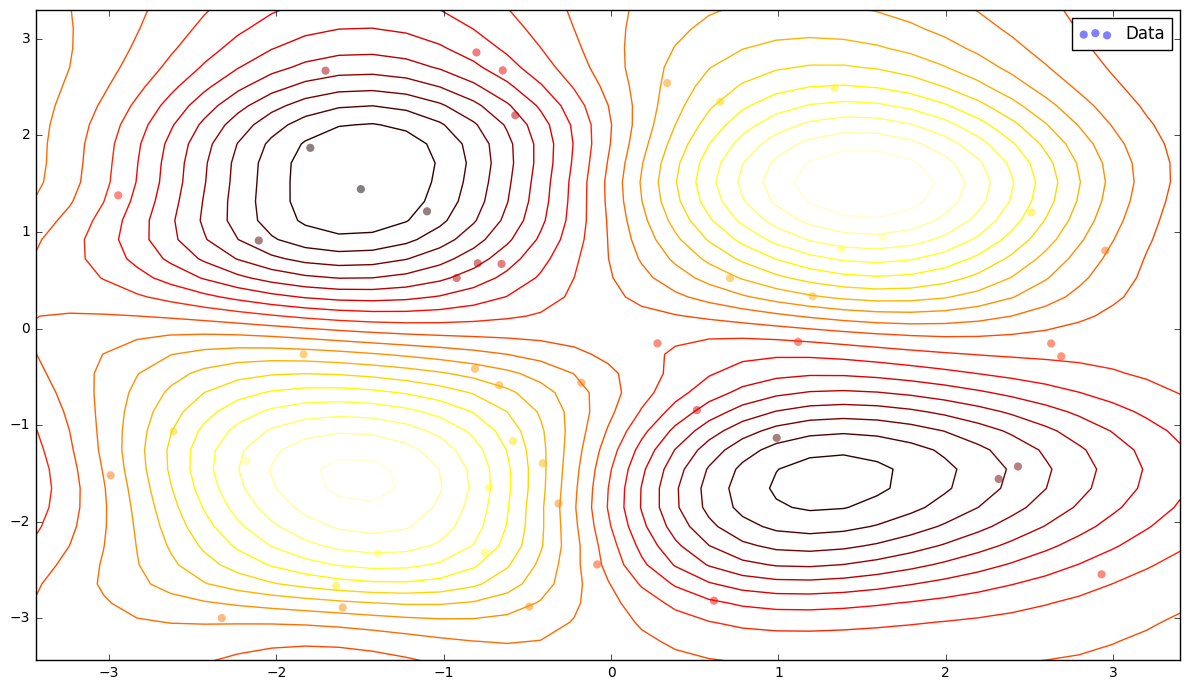

In [35]:
# sample inputs and outputs from 2d model
X2 = np.random.uniform(-3.,3.,(50,2))
Y2 = np.sin(X2[:,0:1]) * np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

# define a sum kernel, where the first dimension is modelled with an RBF, and the second dimension is modelled with a linear kerel
ker = GPy.kern.RBF(input_dim=1, active_dims=[0]) * GPy.kern.Matern32(input_dim=1, active_dims=[1])

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

If we want to plot the marginal of the model where we fix one input to a certain value, we can use "fixed_inputs", the format for which is a list of tuples, where we specify the dimension, and the fixed value.

Here we fix the first dimension (the domain of the linear kernel) to 0.2

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


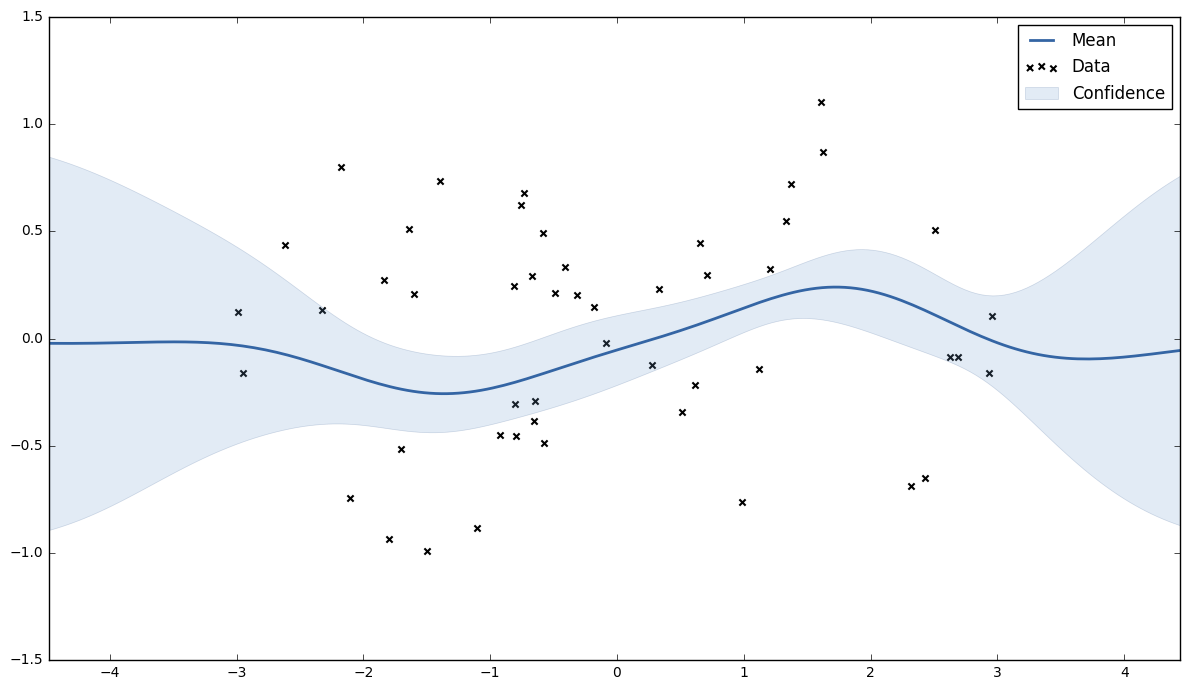

In [36]:
_ = m2.plot(fixed_inputs=[(1, 0.2)])

And then lets fix the zeroth dimension (domain of rbf) to 1.0

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


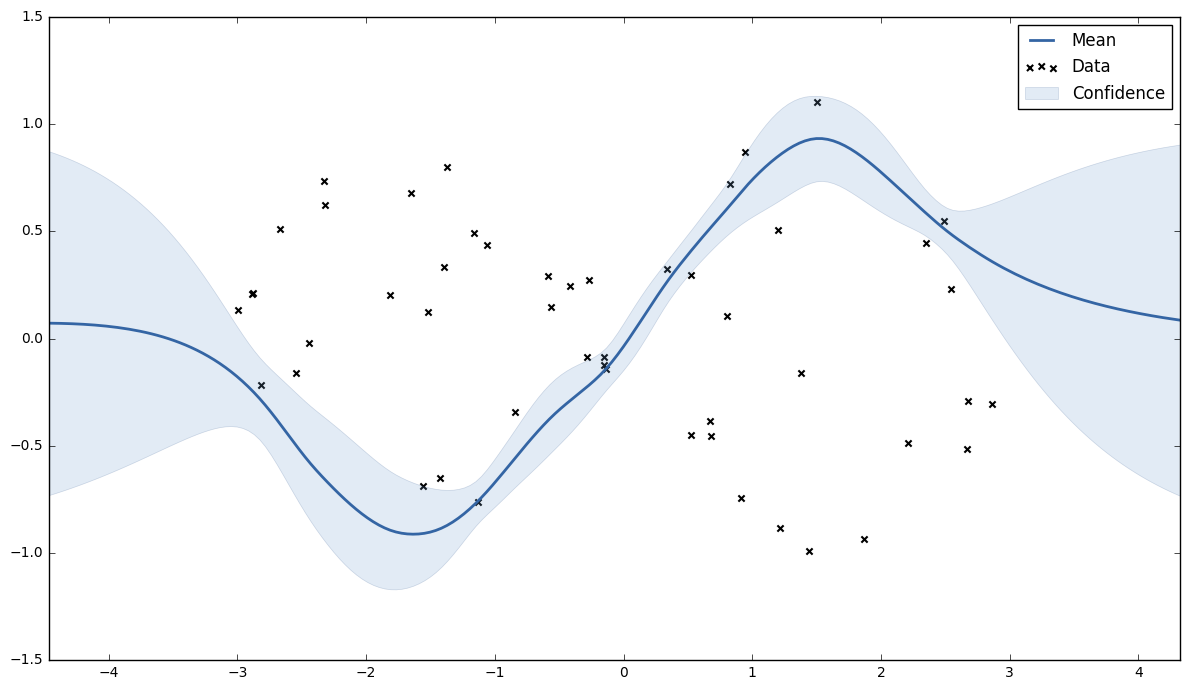

In [37]:
_ = m2.plot(fixed_inputs=[(0, 1.0)])

As we would expect, the data doesn't necessarily sit on the posterior distribution, as this is a projection of all the data onto one dimension.

### 3. 2D Branin function


Consider the [Branin](https://www.sfu.ca/~ssurjano/branin.html) function, which takes a 2d input.

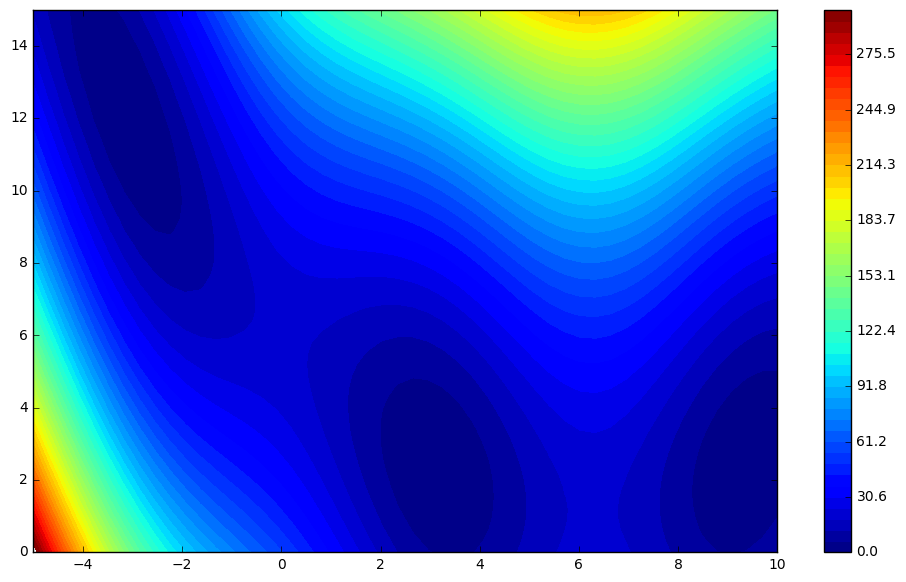

In [38]:
# Definition of the Branin test function
def branin(X):
    y = (X[:,1]-5.1/(4*np.pi**2)*X[:,0]**2+5*X[:,0]/np.pi-6)**2
    y += 10*(1-1/(8*np.pi))*np.cos(X[:,0])+10
    return(y)

# Lets plot it first on a 50*50 grid:
xg1 = np.linspace(-5,10,50)
xg2 = np.linspace(0,15,50)
Xbranin = np.zeros((xg1.size * xg2.size,2))
for i,x1 in enumerate(xg1):
    for j,x2 in enumerate(xg2):
        Xbranin[i+xg1.size*j,:] = [x1,x2]

Ybranin = branin(Xbranin)[:,None]
plt.contourf(xg1, xg2, Ybranin.reshape((50, 50)), levels=np.linspace(0, 300,50))
plt.colorbar()

### Exercise 3a

 Create a maximin latin hypercube design on $[-5,10]\times [0,15]$ consisting of 20 points.

Fit a GPy using 
- an RBF kernel with different length-scales in each direction. The option `ARD=True` (ARD=automatic relevance determination) tells GPy to use an anistropic kernel, i.e., to allow a different length-scale for the x1 direction and the x2 direction.

Now we will fit a GP that is the product of  different kernels in different input. Fit a GP that uses an RBF for x1, and an Matern3/2 for x2.
In this case, we want one kernel to work on one set of dimensions, and another kernel on another set. That is the two kernels work on different domains of the input. You will need to use the active_dims argument to the kernel, which tell the kernel what inputs to work on.
Notice that this is different to simply multiplying two kernels which both take two inputs. 


Finally, try using 
- a kernel that is the product of a RBF kernel for dimension 1 and a linear kernel for direction 2. Does that look sensible?
- a kernel that is the sum of an RBF kernel for dimension 1 and another RBF kernel for dimension 2. This is a type of GAM (Generalised additive model) - it is unlikely to work well here.
- If you used a latin hypercube design, try using a grid (factorial) design instead, what difference do you see?

## 5 More Advanced: Uncertainty propagation

Let $X$ be a random variable defined over the real numbers, $\Re$, and $f(\cdot)$ be a function mapping between the real numbers $\Re \rightarrow \Re$. Uncertainty
analysis is the study of the distribution of the random variable $f ( X )$.

As an exercise here, we will assume that we are interested in the distribution of $f (U )$ where $U$ is a
random variable with uniform distribution over the input space of $f$, and where $f$ is the Branin function. We will focus on
the computation of two quantities: $E[ f (U )]$ and $P( f (U ) > 200)$.

### 5.1 Computation of E[ f (U )]

The expectation of $f (U )$ is given by $\int_x f ( x )\text{d}x$. A basic approach to approximate this
integral is to compute the mean of the 25 observations: `np.mean(Y)`. Since the points
are distributed on a grid, this can be seen as the approximation of the integral by a
rough Riemann sum. The result can be compared with the actual mean of the Branin
function which is 54.31.

Alternatively, we can fit a GP model and compute the integral of the best predictor
by Monte Carlo sampling, i.e., by simulating $U_i ~ U[-5,10]\times U[0,15]$, and then evaluating
$$I = \frac{1}{n} \sum_{i=1}^n \tilde{f}(U_i)$$ where $\tilde{f}$ denotes the GP model.

In [39]:
try:
    from pyDOE import lhs
    # sample inputs and outputs from 2d model
    Xbranin_training = lhs(2, samples=20, criterion='maximin')*6.-3. # you will need to have installed pyDOE for this to work. 
except:
    # Else uncomment the line below
    Xbranin_training = np.random.uniform((-5, 0),(10, 15),(20,2))

Ybranin_training = branin(Xbranin_training)[:, None]

Optimization restart 1/5, f = 36.805258227856356
Optimization restart 2/5, f = 36.80432910717798
Optimization restart 3/5, f = 36.8074762712193
Optimization restart 4/5, f = 36.804134538462925
Optimization restart 5/5, f = 36.804415388099024


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


33.67674387566759

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


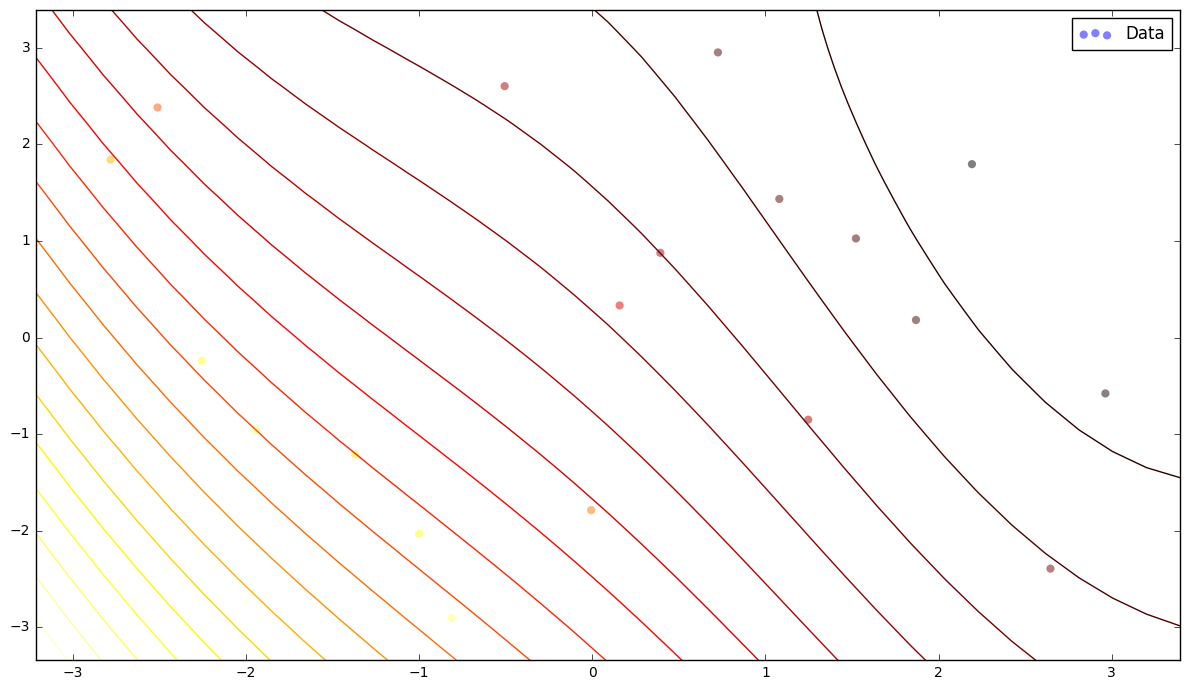

In [40]:
# Fit a GP
# Create an exponentiated quadratic plus bias covariance function
kg = GPy.kern.RBF(input_dim=2, ARD = True)
kb = GPy.kern.Bias(input_dim=2)
k = kg + kb

# Build a GP model
m = GPy.models.GPRegression(Xbranin_training,Ybranin_training,k)

# fix the noise variance
m.likelihood.variance.fix(1e-5)

# Randomize the model and optimize
#m.randomize()
m.optimize_restarts(5, robust=True)

# Plot the resulting approximation to Brainin
# Here you get a two-d plot becaue the function is two dimensional.
m.plot()

# Compute the mean of model prediction on 1e5 Monte Carlo samples
Xp = np.random.uniform(size=(1e5,2))
Xp[:,0] = Xp[:,0]*15-5
Xp[:,1] = Xp[:,1]*15
mu, var = m.predict(Xp)
np.mean(mu)

### Exercise 5a

a) Has the approximation of the mean been improved by using the GP model?

b) One particular feature of GPs we have not use for now is their prediction variance. Can you use it to define some confidence intervals around the previous result?

### 5.2 Computation of $P( f (U ) > 200)$

In various cases it is interesting to look at the probability that $f$ is greater than a given
threshold. For example, assume that $f$ is the response of a physical model representing
the maximum constraint in a structure depending on some parameters of the system
such as Young’s modulus of the material (say $Y$) and the force applied on the structure
(say $F$). If the later are uncertain, the probability of failure of the structure is given by
$P( f (Y, F ) > \text{f_max} )$ where $f_\text{max}$ is the maximum acceptable constraint.

### Exercise 5b

a) As previously, use the 25 observations to compute a rough estimate of the probability that $f (U ) > 200$.

b) Compute the probability that the best predictor is greater than the threshold.

c) Compute some confidence intervals for the previous result

These two values can be compared with the actual value {$P( f (U ) > 200) = 1.23\times 10^{−2}$ .

We now assume that we have an extra budget of 10 evaluations of f and we want to
use these new evaluations to improve the accuracy of the previous result.

### Exercise 5c

a) Given the previous GP model, where is it interesting to add the new observations if we want to improve the accuracy of the estimator and reduce its variance?

b) Can you think about (and implement!) a procedure that updates sequentially the model with new points in order to improve the estimation of $P( f (U ) > 200)$?